# Homework 4: Volatility models

In [1]:
import arch
from arch.__future__ import reindexing

import wrds
import pandas as pd
import numpy as np
import math
import scipy.stats

from statsmodels.formula.api import ols
from statsmodels.stats.diagnostic import het_arch
from statsmodels.graphics.tsaplots import acf, plot_acf, pacf, plot_pacf
from scipy.optimize import minimize

from matplotlib import pyplot as plt

import os
from dotenv import load_dotenv
load_dotenv();

In [2]:
conn = wrds.Connection(wrds_username=os.environ['WRDS_USERNAME'])
FF3F = conn.get_table(library='ff_all',table='factors_monthly',coerce_float=True)
FF3F['month'] = pd.to_datetime(FF3F['date']).dt.to_period('M')
FF3F = FF3F.drop('date',axis=1).set_index('month')
FF3F = FF3F['2010-01':'2020-04']
conn.close()

Loading library list...
Done


### The data you will use:

We will look at monthly returns to three basic strategies in the stock market. 

We will measure all three as *log* returns, to be consistent with our examples from class, though this makes very little difference to the results. Remember that if the return in any date is $r$, then the log return is $\ln(1+r)$.

**Market return** as a benchmark:

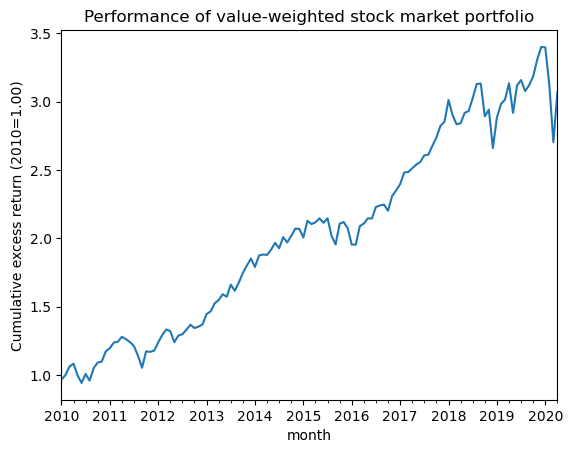

In [3]:
MKT = np.log(1+FF3F['mktrf'])
np.exp(MKT.cumsum()).plot(title="Performance of value-weighted stock market portfolio",ylabel="Cumulative excess return (2010=1.00)");

**UMD**: The return to a dollar-neutral strategy that goes long high-momentum stocks and short low-momentum stocks
<br>
*(and holds the proceeds from the short sale in cash earning zero interest)*

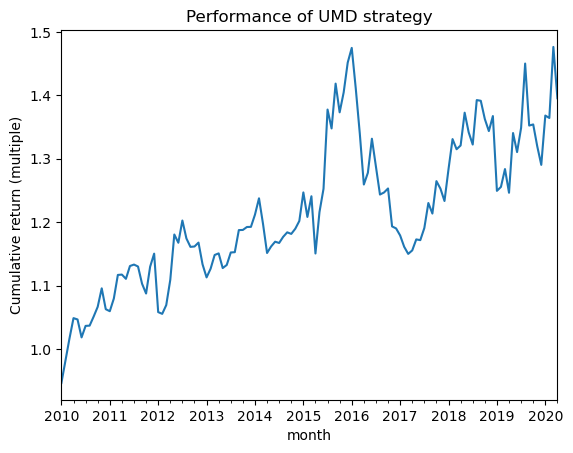

In [4]:
UMD = np.log(1+FF3F['umd'])
np.exp(UMD.cumsum()).plot(title="Performance of UMD strategy",ylabel="Cumulative return (multiple)");

**HML**: The return to a dollar-neutral strategy that goes long value stocks and short growth stocks 
<br>
*(and holds the proceeds from the short sale in cash earning zero interest)*

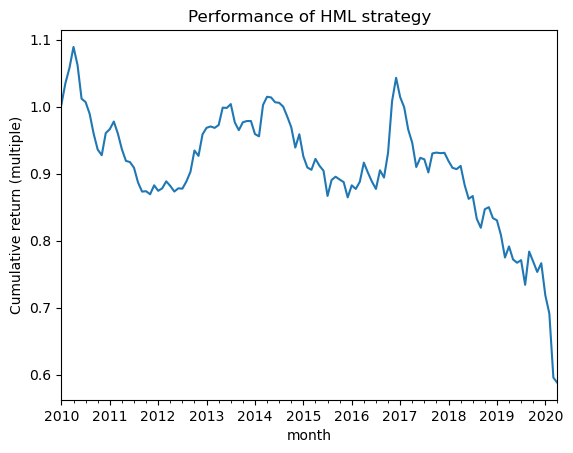

In [5]:
HML = np.log(1+FF3F['hml'])
np.exp(HML.cumsum()).plot(title="Performance of HML strategy",ylabel="Cumulative return (multiple)");

**"Combo"**: The return to a strategy that maintains 50% dollar weighting on UMD, and 50% on HML. Some practitioners (notably AQR) advocate this form of diversification across strategies as a way to get a better risk/return tradeoff.

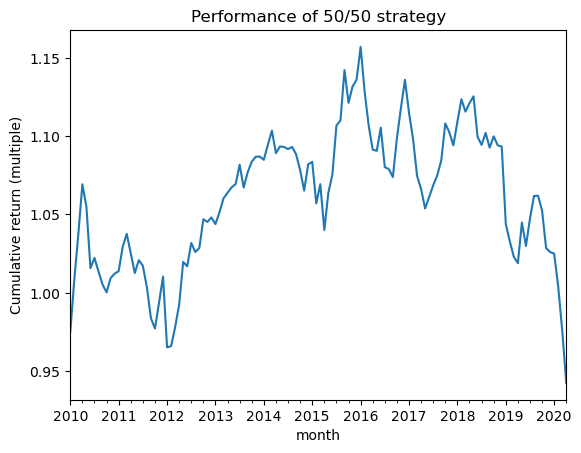

In [6]:
Combo = np.log(1 + 0.5*FF3F['umd'] + 0.5*FF3F['hml']) # corrected version
np.exp(Combo.cumsum()).plot(title="Performance of 50/50 strategy",ylabel="Cumulative return (multiple)");

### Your task:

You will consider the value-at-risk of several strategies in the stock market, at a time of high recent market volatility, April 2020.

For each of the three strategies mentioned above (UMD, HML, and "Combo"), perform the following steps:
- (a) Calculate the 12-month 5% value-at-risk ignoring any time-series effects in volatility (that is, assuming that volatility is a constant number).
- (b) Use Engle’s ARCH-LM test to show that the analysis in (a) is actually invalid.
- (c) Estimate a GARCH(1,1) model of the volatility of the strategy’s returns.
- (d) Show that when we apply Engle’s ARCH-LM test to the residuals from the model in part (c), we fail to reject the null hypothesis, and explain what this means.
- (e) Plot the GARCH estimates of conditional volatility over time.
- (f) Calculate the 12-month 5% value-at-risk based on the GARCH estimates. 

Final questions: 
- Why is your answer to (f) always greater than your answer to (a)?
- Why is your answer to (f) lower for the "Combo" strategy, than for either of the two strategies UMD or HML on its own?